# Train AutoEncoder 

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from lerobot.datasets.lerobot_dataset import LeRobotDataset

/home/joy4mj/miniconda3/envs/so101/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
repo_id = "mjkim00/Feel2Grasp"
revision = "main" 

ds = LeRobotDataset(repo_id, revision=revision, video_backend="pyav") if revision else LeRobotDataset(repo_id)
print("len(ds) =", len(ds))
print("meta =", ds.meta)


len(ds) = 53936
meta = LeRobotDatasetMetadata({
    Repository ID: 'mjkim00/Feel2Grasp',
    Total episodes: '200',
    Total frames: '53936',
    Features: '['action', 'observation.state', 'observation.images.front', 'observation.images.left', 'observation.images.right', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index']',
})',



In [ ]:
idx = 0
sample = ds[idx]

print("keys:", list(sample.keys()))
img = sample["observation.images.front"]

img = torch.as_tensor(img)
print("front dtype:", img.dtype)
print("front shape:", tuple(img.shape))  # (C,H,W) or (T,C,H,W)


keys: ['observation.images.front', 'observation.images.left', 'observation.images.right', 'action', 'observation.state', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'task']
front dtype: torch.float32
front shape: (3, 480, 640)


In [ ]:
image_key = "observation.images.front"
resize_hw = (128, 128)  

def resize_chw(img_chw: torch.Tensor, hw):
    img = img_chw.unsqueeze(0)  # [1,C,H,W]
    img = F.interpolate(img, size=hw, mode="bilinear", align_corners=False, antialias=True)
    return img.squeeze(0)

class FrontOnlyDataset(torch.utils.data.Dataset):
    def __init__(self, ds, image_key="observation.images.front", resize_hw=(128,128)):
        self.ds = ds
        self.image_key = image_key
        self.resize_hw = resize_hw

        probe = self.ds[0]
        if self.image_key not in probe:
            raise KeyError(f"{self.image_key} not in keys")

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        s = self.ds[idx]
        img = torch.as_tensor(s[self.image_key])  # (3,480,640), float32
        img = img.clamp(0.0, 1.0)                 
        img = resize_chw(img, self.resize_hw)     # (3,128,128)
        return img

img_ds = FrontOnlyDataset(ds, image_key=image_key, resize_hw=resize_hw)
loader = DataLoader(img_ds, batch_size=64, shuffle=True, num_workers=4,
                    pin_memory=torch.cuda.is_available(), drop_last=True)

batch = next(iter(loader))
print("batch:", batch.shape, batch.dtype, batch.min().item(), batch.max().item())  # (B,3,128,128)

batch: torch.Size([64, 3, 128, 128]) torch.float32 0.026116954162716866 0.8596745133399963


In [10]:
import torch.nn as nn

class ConvEncoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(inplace=True),    # 128 -> 64
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(inplace=True),   # 64 -> 32
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(inplace=True),  # 32 -> 16
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(inplace=True), # 16 -> 8
            nn.AdaptiveAvgPool2d((4, 4)),
        )
        self.fc = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        return self.fc(self.net(x).flatten(1))

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim: int, out_hw):
        super().__init__()
        self.out_hw = out_hw
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, 4, 2, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        h = self.fc(z).view(z.size(0), 256, 4, 4)
        x_hat = self.net(h)
        if (x_hat.shape[-2], x_hat.shape[-1]) != self.out_hw:
            x_hat = F.interpolate(x_hat, size=self.out_hw, mode="bilinear", align_corners=False, antialias=True)
        return x_hat

class AutoEncoder(nn.Module):
    def __init__(self, latent_dim: int, out_hw):
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim, out_hw)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [ ]:
import os
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm



device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 64
epochs = 10
lr = 3e-4
weight_decay = 1e-6
out_dir = "./ae_out"
os.makedirs(out_dir, exist_ok=True)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

ae = AutoEncoder(latent_dim, resize_hw).to(device)
opt = torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

ae.train()
for ep in range(1, epochs + 1):
    running = 0.0

    pbar = tqdm(loader, desc=f"Epoch {ep}/{epochs}", leave=True)
    for imgs in pbar:
        # imgs: (B,3,480,640) or (B,3,128,128)
        imgs = imgs.to(device, non_blocking=True)

        imgs = F.interpolate(
            imgs,
            size=resize_hw,          # (H,W)
            mode="bilinear",
            align_corners=False,
            antialias=True,
        )

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device == "cuda")):
            recon = ae(imgs)
            loss = F.mse_loss(recon, imgs)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        running += float(loss.item())
        pbar.set_postfix(mse=running / (pbar.n + 1))

    print(f"epoch {ep:03d} | mse {running/len(loader):.6f}")

# save encoder
torch.save(
    {
        "repo_id": repo_id,
        "revision": revision,
        "image_key": image_key,
        "resize_hw": resize_hw,
        "latent_dim": latent_dim,
        "encoder_state_dict": ae.encoder.state_dict(),
    },
    os.path.join(out_dir, "encoder.pt"),
)

print("saved:", os.path.join(out_dir, "encoder.pt"))


/tmp/ipykernel_91251/1383987761.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))
Epoch 1/10:   0%|          | 0/842 [00:00<?, ?it/s]/tmp/ipykernel_91251/1383987761.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device == "cuda")):
Epoch 1/10: 100%|██████████| 842/842 [04:56<00:00,  2.84it/s, mse=0.00562]


epoch 001 | mse 0.005621


Epoch 2/10: 100%|██████████| 842/842 [04:59<00:00,  2.81it/s, mse=0.00131]


epoch 002 | mse 0.001305


Epoch 3/10: 100%|██████████| 842/842 [04:49<00:00,  2.91it/s, mse=0.00094] 


epoch 003 | mse 0.000940


Epoch 4/10: 100%|██████████| 842/842 [04:54<00:00,  2.86it/s, mse=0.00077] 


epoch 004 | mse 0.000770


Epoch 5/10: 100%|██████████| 842/842 [05:04<00:00,  2.76it/s, mse=0.000661]


epoch 005 | mse 0.000660


Epoch 6/10: 100%|██████████| 842/842 [04:50<00:00,  2.90it/s, mse=0.000585]


epoch 006 | mse 0.000585


Epoch 7/10: 100%|██████████| 842/842 [04:52<00:00,  2.88it/s, mse=0.000529]


epoch 007 | mse 0.000529


Epoch 8/10: 100%|██████████| 842/842 [05:06<00:00,  2.75it/s, mse=0.000484]


epoch 008 | mse 0.000484


Epoch 9/10: 100%|██████████| 842/842 [04:54<00:00,  2.86it/s, mse=0.000447]


epoch 009 | mse 0.000447


Epoch 10/10: 100%|██████████| 842/842 [04:55<00:00,  2.85it/s, mse=0.000419]

epoch 010 | mse 0.000419
saved: ./ae_out/encoder.pt


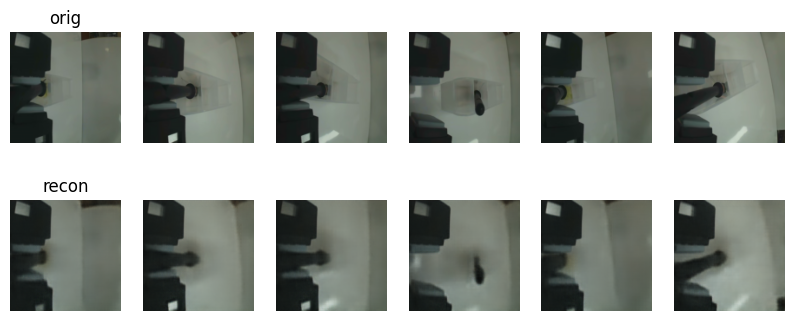

In [12]:
ae.eval()
imgs = next(iter(loader))[:6].to(device)
with torch.no_grad():
    recon = ae(imgs).cpu()
imgs = imgs.cpu()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,6,i+1)
    plt.imshow(imgs[i].permute(1,2,0))
    plt.axis("off")
    if i==0: plt.title("orig")
    plt.subplot(2,6,6+i+1)
    plt.imshow(recon[i].permute(1,2,0))
    plt.axis("off")
    if i==0: plt.title("recon")
plt.show()


## Extract visual feature

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

class ConvEncoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4)),
        )
        self.fc = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        return self.fc(self.net(x).flatten(1))

ckpt = torch.load("./ae_out/encoder.pt", map_location="cpu")

encoder = ConvEncoder(ckpt["latent_dim"])
encoder.load_state_dict(ckpt["encoder_state_dict"])
encoder.to(device).eval()

# In RL, freeze the encoder
for p in encoder.parameters():
    p.requires_grad_(False)

resize_hw = tuple(ckpt["resize_hw"])


In [ ]:
@torch.no_grad()
def encode_front(front_chw: torch.Tensor) -> torch.Tensor:
    """
    front_chw: (3,H,W) float in [0,1]
    return: (latent_dim,)  e.g. (64,)
    """
    x = front_chw.unsqueeze(0).to(device)  # (1,3,H,W)
    x = F.interpolate(x, size=resize_hw, mode="bilinear", align_corners=False, antialias=True)
    z = encoder(x)                         # (1,latent_dim)
    return z.squeeze(0).float().cpu()      


In [15]:
sample = ds[0]
front = torch.as_tensor(sample["observation.images.front"]).clamp(0,1)  # (3,480,640)
z = encode_front(front)
print(z.shape)  # torch.Size([64])


torch.Size([64])
